In [1]:
# Author: Zuolin Liu (zliu653)
'''
block #1
This block imports libraries
'''
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib
import math
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
solvers.options['abstol'] = 1e-4
solvers.options['reltol'] = 1e-4
solvers.options['feastol'] = 1e-4

In [2]:
'''
block #2
This block sets fixed parameters
'''
GAMMA = 0.9
MIN_ALPHA = 0.001
MIN_EPSILON = 0.001
# random.seed(20190721)

In [3]:
'''
block #3
This block implements the scoccer environment
'''
class Player():
    '''
    the player class stores a player's position
    '''
    def __init__(self, position):
        self.position = position

class Soccer(): 
    '''
    the soccer class
    '''
    def __init__(self, width=4, height=2, num_player=2):
        self.width = width
        self.height = height
        self.num_player = num_player
        self.goals = [0, self.width-1]
        self.player_order = [i for i in range(num_player)]
        self.delta_pos = ((0,1),(0,-1),(1,0),(-1,0),(0,0)) # N, S, E, W, stick
    
    def reset(self, positions=((2,1),(1,1)), has_ball=1):
        '''
        reset the environment and return the new starting state
        '''
        self.players = [Player(positions[i]) for i in range(self.num_player)]
        self.done = False  
        self.has_ball = has_ball
        return [self.flatten(self.players[0].position), 
                self.flatten(self.players[1].position),
               self.has_ball]
    
    def predict_position(self, current_pos, action):
        '''
        calulate the player's position according to his current position and the action he takes
        '''
        delta_x, delta_y = self.delta_pos[action]
        x = current_pos[0] + delta_x
        y = current_pos[1] + delta_y
        if x < 0 or x > self.width - 1:
            x = current_pos[0]
        if y < 0 or y > self.height -1:
            y = current_pos[1]
        return x, y
    
    def flatten(self, position):
        '''
        convert a player's position into a number
        '''
        return position[1]*self.width+position[0]  
    
    def check_game_over(self, player):
        '''
        determine if the game is over by checking if the player who has the ball is in one of the
        goal states
        return rewards and flip the done flag if this round of game is over
        '''
        rewards = [0] * self.num_player
        if self.has_ball == player:
            if self.players[player].position[0] == self.goals[player]: 
                rewards[player] = 100
                rewards[1-player] = -100
                self.done = True
            if self.players[player].position[0] == self.goals[1-player]:
                rewards[player] = -100
                rewards[1-player] = 100
                self.done = True
        return rewards
   
    def step(self, actions):
        '''
        each player take a step
        '''
        desired_positions = [self.predict_position(self.players[i].position, actions[i]) 
                             for i in range(self.num_player)]      
        random.shuffle(self.player_order) 
        
        for player in self.player_order:
            rewards = self.check_game_over(player)
            if self.done:
                return None, rewards, self.done
            if desired_positions[player] != self.players[1-player].position:
                self.players[player].position = desired_positions[player]
            elif self.has_ball == player:
                self.has_ball = 1 - player
            rewards = self.check_game_over(player)
            if self.done:
                return None, rewards, self.done

        return [self.flatten(self.players[0].position), 
            self.flatten(self.players[1].position),
           self.has_ball], rewards, self.done

In [15]:
'''
block #4
Different flavors of learners
'''

class Base_Q():
    '''
    the base class to share common functions
    '''
    def __init__(self, num_states, num_actions, num_players=2):
        '''
        initialize Q table with ones
        initialize other parameters
        '''
        self.Q = [np.ones((num_states, num_states, num_players, num_actions, num_actions))
                 for _ in range(num_players)]
        self.num_players = num_players
        self.num_actions = num_actions
        self.alpha = MAX_ALPHA 
        self.steps = 1
           
    def update(self, state, state_p, actions, rewards):
        '''
        update Q table for both players
        '''
        for player in range(self.num_players):
            old_Q = self.get_old_Q(player, state, [actions[player], actions[1-player]])      
            future_v = self.get_future_value(player, state_p)
            new_Q = (1.0-self.alpha)*old_Q+self.alpha*((1.0-GAMMA)*rewards[player]+GAMMA*future_v)
            self.assign_new_Q(player, state, actions, new_Q)
        self.update_parameters()
    
    def get_old_Q(self, player, state, actions):
        '''
        retrive the current Q
        '''
        return self.Q[player][state[0], state[1], state[2], actions[0], actions[1]]
    
    def assign_new_Q(self, player, state, actions, new_Q):
        '''
        update Q value at certain state-actions
        '''
        self.Q[player][state[0], state[1], state[2], actions[0], actions[1]] = new_Q

    def update_parameters(self):
        '''
        update alpha
        '''
        self.alpha = MIN_ALPHA+(MAX_ALPHA - MIN_ALPHA) * math.exp(-ALPHA_DECAY * self.steps)
        self.steps +=1
    
    def query(self, state):
        '''
        determine actions by random
        '''
        return random.choices(range(self.num_actions), k=2)
    

class Friend_Q(Base_Q):       
    def get_future_value(self, player, state):
        '''
        V(s') is the maximum value over all action pairs
        '''
        if not state:
            return 0
        return np.max(self.Q[player][state[0], state[1], state[2],:,:])
    
class Foe_Q(Base_Q):
    def get_future_value(self, player, state):
        '''
        solve V(s') using linear programing
        '''
        if not state:
            return 0
        c = matrix([-1.]+[0.]*self.num_actions)
        b = matrix([0.]*self.num_actions+[1., -1.] + [0.]*self.num_actions + [1.]*self.num_actions)
        A = []
        for i in range(self.num_actions):
            A += [[1.] + list(self.Q[player][state[0], state[1], state[2],i,:])]
        A += [[0.]+[1. for _ in range(self.num_actions)]]
        A += [[0.]+[-1. for _ in range(self.num_actions)]]
        for i in range(self.num_actions):
            A += [[0.] +[-1. if j == i else 0. for j in range(self.num_actions)]]
                  
        for i in range(self.num_actions):  
            A += [[0.] +[1. if j == i else 0. for j in range(self.num_actions)]]
        
        A = matrix(list(map(list, zip(*A))))
        p = list(solvers.lp(c,A,b, solver='glpk')['x'])
        return -p[0]
    
class Correlated_Q(Base_Q): 
    def update(self, state, state_p, actions, rewards):
        '''
        update Q table for both players
        '''
        v = self.get_future_value(0, state_p)
        for player in range(self.num_players):
            old_Q = self.get_old_Q(player, state, [actions[player], actions[1-player]])      
            future_v = v[player]
            new_Q = (1.0-self.alpha)*old_Q+self.alpha*((1.0-GAMMA)*rewards[player]+GAMMA*future_v)
            self.assign_new_Q(player, state, [actions[player], actions[1-player]], new_Q)
        self.update_parameters()

    def get_future_value(self, player, state):
        '''
        solve V(s') using linear programing
        '''
        if not state:
            return [0,0]
        A = []
        for i in range(self.num_actions):            
            for j in range(self.num_actions):
                row = [0.] * (i*self.num_actions)
                if i != j:
                    row += [self.Q[0][state[0], state[1], state[2],j,k]
                            -self.Q[0][state[0], state[1], state[2],i,k] 
                             for k in range(self.num_actions)]
                    row += [0.]*((self.num_actions-i-1)*self.num_actions)
                    A += [[0.]+row]
    
        for i in range(self.num_actions):            
            for j in range(self.num_actions):
                row = [0.] * self.num_actions**2
                if i != j:
                    for k in range(self.num_actions):
                        row[k*self.num_actions+i] = \
                        self.Q[1][state[0], state[1], state[2],j,k]\
                          - self.Q[1][state[0], state[1], state[2],i,k]
                    A += [[0.]+row]
                    
        A += [[0.]+[1. for _ in range(self.num_actions**2)]]
        A += [[0.]+[-1. for _ in range(self.num_actions**2)]]
        for i in range(self.num_actions**2):
            A += [[0.]+[-1. if j == i else 0. for j in range(self.num_actions**2)]]
            
        for i in range(self.num_actions**2):
            A += [[0.]+[1. if j == i else 0. for j in range(self.num_actions**2)]] 
        A += [[-1.]+[self.Q[0][state[0], state[1], state[2],
                                    i//self.num_actions,i%self.num_actions] \
                     + self.Q[1][state[0], state[1], state[2],
                                        i%self.num_actions,i//self.num_actions]
                    for i in range(self.num_actions**2)]]

        A = matrix(list(map(list, zip(*A))))
        b = matrix([0.]*((self.num_actions-1)*self.num_actions*2)
                   +[1., -1.] 
                   + [0.]*self.num_actions**2 
                   + [1.]*self.num_actions**2 
                   + [0.])
        
        c = matrix([1.]+[0.]*self.num_actions**2)
        try:
            p = list(solvers.lp(c,A,b)['x'])
    
            A = sum([p[i+1]*self.Q[0][state[0], state[1], state[2],
                                           i//self.num_actions,
                                           i%self.num_actions]
                       for i in range(self.num_actions**2)]) 
            B = sum([p[i+1]*self.Q[1][state[0], state[1], state[2],
                                             i%self.num_actions,
                                             i//self.num_actions]
                       for i in range(self.num_actions**2)])
            return [A, B]
        except:
            return [0,0]
    
class Q_learner(Base_Q):
    '''
    Q learner class
    '''
    def __init__(self, num_states, num_actions, num_players=2):
        '''
        initialize Q values as ones
        initialize epsilon
        '''
        super().__init__(num_states, num_actions)
        self.Q = [np.ones((num_states, num_states, num_players, num_actions)) 
                  for _ in range(num_players)]
        self.epsilon = MAX_EPSILON

    def get_old_Q(self, player, state, actions):
        '''
        retrive the current Q
        '''
        return self.Q[player][state[0],state[1], state[2], actions[0]]
    
    def assign_new_Q(self, player, state, actions, new_Q):
        '''
        assign Q for specific state-actions pair
        '''
        self.Q[player][state[0],state[1], state[2],actions[0]] = new_Q 
    
    def get_future_value(self, player, state):
        '''
        get V_p using state_p
        the maxium Q values over all actions of the player
        '''
        if not state:
            return 0
        return np.max(self.Q[player][state[0],state[1], state[2],:])
    
    def update_parameters(self):
        '''
        update learning rate and epsilon
        '''
        self.alpha = MIN_ALPHA+(MAX_ALPHA - MIN_ALPHA) *math.exp(-ALPHA_DECAY * self.steps)
        self.epsilon = MIN_EPSILON+(MAX_EPSILON-MIN_EPSILON)*math.exp(-EPSILON_DECAY*self.steps)
        self.steps +=1
    
    def update(self, state, state_p, actions, rewards):
        '''
        update Q table for both players
        '''
        for player in range(self.num_players):
            old_Q = self.get_old_Q(player, state, [actions[player], actions[1-player]])      
            future_v = self.get_future_value(player, state_p)
            new_Q = (1.0-self.alpha)*old_Q+self.alpha*((1.0-GAMMA)*rewards[player]+GAMMA*future_v)
            self.assign_new_Q(player, state, [actions[player], actions[1-player]], new_Q)
        self.update_parameters()
       
    
    def query(self, state):
        '''
        determine actions for both players based on the state, random or by policy
        '''
        if random.random() < self.epsilon:
            return random.choices(range(self.num_actions), k=2)
        else:
            return [np.argmax(self.Q[i][state[0], state[1], state[2],:]) 
                    for i in range(self.num_players)]

class Environment():
    '''
    the environment wrapper to run the experiments
    '''
    def __init__(self, num_player=2):
        self.environment = Soccer()
        self.num_player = num_player
        self.Q_diffs = []
        self.actions = []
        self.states = []
        
    def run(self, agent, num_iterations):
        s = self.environment.reset()
        old_Q = 1.0
        done = True
        initial_states = [(1,0), (2,0),(1,1),(2,1)]
        for i in range(num_iterations):
            if done:
                state = self.environment.reset(positions=random.sample(initial_states, k=2), 
                                              has_ball=random.choice([0,1]))
                done = False
            actions = agent.query(state)
            state_p, rewards, done = self.environment.step(actions)                
            agent.update(state, state_p, actions, rewards)

            if len(agent.Q[0].shape) == 4:
                new_Q = agent.Q[0][s[0],s[1], s[2],1]
            else:
                new_Q = agent.Q[0][s[0],s[1], s[2],1,4]
            self.Q_diffs += [abs(old_Q - new_Q)]
            self.actions += [actions]
            self.states += [state]
            
            old_Q = new_Q
            state = state_p
                      
        print("Final Q values at state s (N, S, E, W, Stick)")
        if len(agent.Q[0].shape) == 4:
            print("Player A: \n", agent.Q[0][s[0],s[1], s[2],:])
            print("Player B: \n", agent.Q[1][s[0],s[1], s[2],:])
        else:
            print("Player A: \n", agent.Q[0][s[0],s[1], s[2],:,:])
            print("Player B: \n", agent.Q[1][s[0],s[1], s[2],:,:])
    

def smooth(Q_diffs):
    '''
    process the result by removing zero values
    '''
    smooth_Q_diff = []
    index = []
    for i in range(len(Q_diffs)):
        if Q_diffs[i] != 0:
            smooth_Q_diff += [Q_diffs[i]]
            index += [i]        
    return index, smooth_Q_diff

def main(learner):
    '''
    run experients
    '''
    environment = Environment()
    num_states = environment.environment.width * environment.environment.height
    num_actions = len(environment.environment.delta_pos)
    agent = AGENT_POOL[learner](num_states, num_actions)
    environment.run(agent, NUM_ITERATIONS)
    
    plt.figure(figsize=(4,3))
    index, Q_diffs = smooth(environment.Q_diffs)
    plt.plot(index, Q_diffs, 'k-', linewidth=0.3)
    plt.xlabel("Simulation Iteration")
    plt.ylabel("Q-Value Difference")
    plt.title(learner)
    plt.ylim([0, 0.5])
    plt.xlim([0, 1000000])
    plt.xticks([100000*i for i in range(11)])
    plt.yticks([i*0.05 for i in range(11)])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5), useMathText=True)
    plt.show()
    
    return environment

AGENT_POOL = {"Friend-Q":Friend_Q, 
              "Foe-Q":Foe_Q, 
              "Correlated-Q":Correlated_Q, 
              "Q-learner":Q_learner}

def analyze(Q_diffs, actions, states):
    '''
    analyze and plot results for Q learner
    '''
    action_lookup = ['N', 'S', 'E', 'W', 'Stick']
    Q_diffs_actions = []
    for action in range(5):
        Q_diffs_actions += [[Q_diffs[i] if actions[i] == [1,action] and states[i] == [6,5,1] else None for i in range(len(Q_diffs))]]
    
    plt.figure(figsize=(4,3))
    for i in range(len(action_lookup)):
        plt.plot(Q_diffs_actions[i], '.')
    plt.xlim([0, 1000000])
    plt.xticks([100000*i for i in range(11)])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5), useMathText=True)
    plt.title("Q-learner")
    plt.ylim([0, 0.5])
    plt.xlabel("Simulation Iteration")
    plt.ylabel("Q-Value Difference")
    plt.legend([action_lookup[i] for i in range(len(action_lookup))], fontsize=8)
    plt.show()

    for i in range(len(action_lookup)):
        plt.figure(figsize=(4,3))
        plt.plot(Q_diffs_actions[i], 'k.')
        plt.xlim([0, 1000000])
        plt.ylim([0, 5])
        plt.xticks([100000*i for i in range(11)])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(5,5), useMathText=True)
        plt.title("Player B's action = " + action_lookup[i])
        plt.xlabel("Simulation Iteration")
        plt.ylabel("Q-Value Difference")
        plt.show()
         

Final Q values at state s (N, S, E, W, Stick)
Player A: 
 [[-2.71843808 -3.02366525  2.38049619 10.         -2.71478526]
 [-3.55962988 -2.72425994 -2.92015424 10.         -3.56583898]
 [-2.94984381 -7.455322   -9.24313357 10.         -2.94786542]
 [-2.7226188  -5.47011401 -0.12193094 10.         -2.71572623]
 [-2.71720628 -3.0135871   2.37969335 10.         -2.71772793]]
Player B: 
 [[  2.71843815   3.55962992   2.95027567   2.72261887   2.71720635]
 [  3.02366529   2.72426001   7.49038166   5.47011403   3.01358714]
 [ -2.38049612   2.92015426   9.25888277   0.12193101  -2.37969328]
 [-10.         -10.         -10.         -10.         -10.        ]
 [  2.71478533   3.56583902   2.94827904   2.7157263    2.717728  ]]


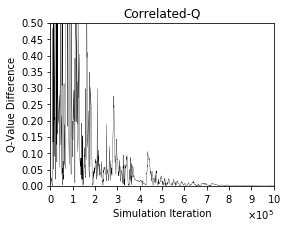

CPU times: user 1h 17min 54s, sys: 54.6 s, total: 1h 18min 49s
Wall time: 19min 42s


In [9]:
'''
block #5
Run Correlated-Q, this block takes ~80 mins
The final Q tables for both players are printed. the rows are player's action 
and coloumns the other player's actions
'''
MAX_ALPHA = 0.5
ALPHA_DECAY = 0.000005
NUM_ITERATIONS = 1000000
%time main("Correlated-Q")

Final Q values at state s (N, S, E, W, Stick)
Player A: 
 [[-2.66563991 -3.06626721  2.37303234 10.         -2.66316592]
 [-3.34939539 -2.65405576 -2.83225641 10.         -3.33962255]
 [-3.08295695 -7.33418327 -9.17069619 10.         -3.08256192]
 [-2.6641572  -5.72019643 -0.18978158 10.         -2.66330089]
 [-2.66585594 -3.08117432  2.37395304 10.         -2.66382366]]
Player B: 
 [[ -4.43017407  -3.16584196   0.82805766  -7.22242986  -4.4327116 ]
 [ -3.16593878  -4.49721225  -0.03530407  -6.59267406  -3.16887012]
 [  0.81182829  -0.04897632   6.37211627  -4.89178422   0.82289974]
 [ -7.21023782  -6.57772698  -4.86936771 -10.          -7.21370887]
 [ -4.43284365  -3.16897765   0.8391553   -7.22600933  -4.42670647]]


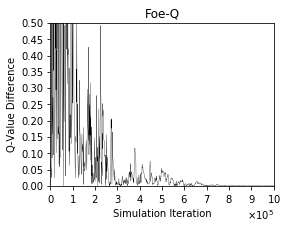

CPU times: user 3min 15s, sys: 15.1 s, total: 3min 30s
Wall time: 3min 30s


In [5]:
'''
block #6
Run Foe-Q, this block takes ~4 mins
The final Q tables for both players are printed. the rows are player's action 
and coloumns the other player's actions
'''
MAX_ALPHA = 0.5
ALPHA_DECAY = 0.000005
NUM_ITERATIONS = 1000000
%time main("Foe-Q")

Final Q values at state s (N, S, E, W, Stick)
Player A: 
 [[ 9.          9.          8.54276858 10.          9.        ]
 [ 9.          9.          8.1        10.          9.        ]
 [ 9.          9.          0.11394828 10.          9.        ]
 [ 9.          9.          8.74473254 10.          9.        ]
 [ 9.          9.          8.54282788 10.          9.        ]]
Player B: 
 [[  8.28647507   8.1          8.35347819  -0.90698706   8.28784675]
 [  8.1          8.3771932    8.55241233  -1.00064408   8.1       ]
 [  8.3463322    8.54746003   9.19143117  -0.70658876   8.34623818]
 [ -0.80671222  -0.90105845  -0.60357797 -10.          -0.80783225]
 [  8.2880386    8.1          8.35337479  -0.90824765   8.28284418]]


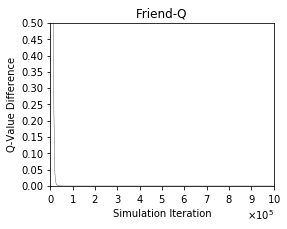

CPU times: user 22.1 s, sys: 754 ms, total: 22.9 s
Wall time: 21.6 s


In [10]:
'''
block #7
Run Friend-Q, this block takes ~30s
The final Q tables for both players are printed. the rows are player's action 
and coloumns the other player's actions
'''
MAX_ALPHA = 0.2
ALPHA_DECAY = 0.000003
NUM_ITERATIONS = 1000000
%time main("Friend-Q")

Final Q values at state s (N, S, E, W, Stick)
Player A: 
 [-2.44265827 -2.2664523  -3.16025188 -2.46541776 -2.44339309]
Player B: 
 [  2.42134562   2.29135422   1.08758171 -10.           2.28265031]


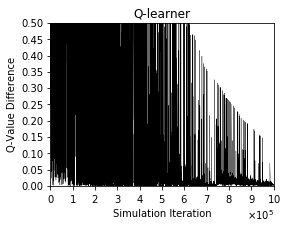

CPU times: user 22.3 s, sys: 136 ms, total: 22.4 s
Wall time: 22.3 s


In [11]:
'''
block #8
Run Q learner,this block takes ~30s
The final Q tables for both players are printed. the rows are player's action 
and coloumns the other player's actions
'''
MAX_ALPHA = 0.5
ALPHA_DECAY = 0.000004
NUM_ITERATIONS = 1000000
MAX_EPSILON = 0.5
EPSILON_DECAY = 0.000004
%time Q_env = main("Q-learner")

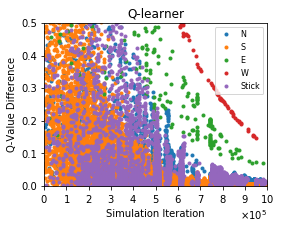

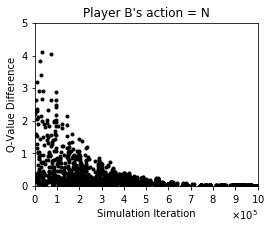

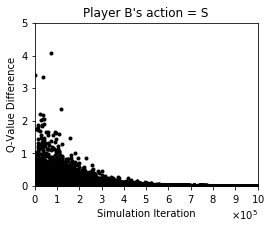

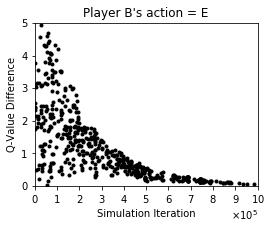

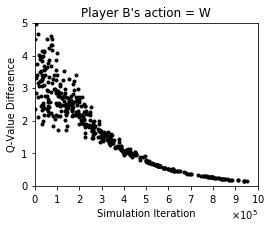

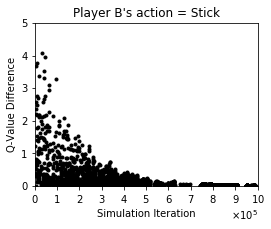

CPU times: user 19.2 s, sys: 548 ms, total: 19.8 s
Wall time: 11.2 s


In [16]:
'''
block #9
Analyze the results of Q learner, this block takes ~30s
The final Q tables for both players are printed. the rows are player's action 
and coloumns the other player's actions
'''
%time analyze(Q_env.Q_diffs, Q_env.actions, Q_env.states)